# Thermal stability of hundreds of point mutants of a family 1 glycoside hydrolase 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import curve_fit 
from numpy import log, exp, linspace, sqrt, diag
from sklearn.linear_model import LinearRegression
import os
import re 

df = pandas.read_csv( 'data/Bagel Thermostability - cleaned_data.csv' )
df.index = df.mutant
df.drop( 'mutant', inplace=True )
df.drop( ['WT', 'WT1'], inplace=True )
df.dropna( inplace=True ) 

def is_good( name ):
    return os.path.isfile( '/Users/alex/Documents/bagel-orders/oligos/{}.fasta'.format( name.lower() ) )

# this is a sanity-checking routine for "off-by-threes" 
l = []
for name in df.index:
    #print name
    if is_good( name ):
        l.append( name )
    else:
        new = name[0] + str( int( re.findall( r'\d+', name )[0] ) - 3 ) + name[-1]
        if is_good( new ):
            l.append( new )
        else:
            l.append( 'drop_me' )
            
df.index = l
df.drop( ['drop_me'], inplace=True )

# temperature keys as CSV files in data/
temp_key = pandas.read_csv( 'data/temp_key.csv' )
temp_key.index = temp_key.Well
df['temp'] = df.well.str[0].map( temp_key.Celsius.to_dict() ) 
df.dropna( inplace=True )

# Curve fit to logistic equation

In [2]:
# logistic equation 
def f(x, x0, k): 
    return 1/(1+exp(-k*(x-x0)))

# util function to fit a mutant 
def fit( df ):
    name = df.mutant.unique()[0]
    df.rate = df.rate / df.rate.max()
    
    # linear fit 
    reg = LinearRegression()
    reg.fit( df.temp.reshape(-1, 1), df.rate )
    slope = reg.coef_[0]
    
    # try fitting to logistic eqn 
    try:
        p0 = ( df.temp.mean(), slope )
        popt, pcov = curve_fit( f, df.temp, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) )
        if 30 < popt[0] < 50: # biological assay limits 
            return pandas.Series( popt, index=['tm', 'k'] )
        else:
            #iffy += [ name ]
            raise Exception( 'Warning: dropping fit for {0} because Tm of {1:2.2f} is outside range 30-50 C'.format( name, popt[0] ) )
    except Exception as e:
        print e
    
grouped = df.groupby( by='mutant' )
fits = grouped.apply( fit )
print ''
print 'Successfully fit {} of {} samples to the logistic equation'.format( len( fits ), len( grouped ) )


Successfully fit 119 of 119 samples to the logistic equation


/Users/alex/Applications/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [3]:
fits

,tm,k
mutant,,
A195S,39.100764,-0.931507
A356A,39.886138,-1.122859
A357A,39.113754,-0.326374
A408A,39.958372,-1.263093
C167A,39.736959,-1.389863
C167Q,38.474155,-0.533021
D403A,NaN,NaN
E154D,38.685433,-0.694347
E164A,NaN,NaN


## Diagnostic plots to help determine goodness of fits

In [4]:
for index, df in grouped:
    name = df.mutant.unique()[0]
    rate = df.rate / df.rate.max() # have to do this again
    plt.figure( figsize=(2,2) )
    plt.scatter( df.temp, rate, alpha=0.7, color='black', marker='.' )
    popt = fits.loc[ name ]
    if popt is not None:
        x_space = linspace( df.temp.min(), df.temp.max(), 100 )
        plt.plot( x_space, f( x_space, *popt ), alpha=0.5, color='purple' )
    plt.xlabel( 'T (C)' )
    plt.ylabel( 'Normalized rate')
    plt.xticks( [ 30, 40, 50 ] )
    plt.yticks( [ 0, 0.5, 1 ] )
    plt.title( name )
    plt.tight_layout()
    plt.savefig( 'plots/%s.pdf' % name, format='pdf' )
    #plt.show()
    plt.close()

## Clean up and apply what we learned from the plots to the data set 

In [5]:
# nothing here, yet! 

In [6]:
# add metadata
fits['native'] = fits.index.str[0]
fits['designed'] = fits.index.str[-1]
fits['position'] = fits.index.str[1:-1].astype( int )
fits.sample( 10 )

,tm,k,native,designed,position
mutant,,,,,
Q19A,NaN,NaN,Q,A,19
S14A,40.025318,-1.572317,S,A,14
E180K,36.644120,-0.671754,E,K,180
N293D,NaN,NaN,N,D,293
E222K,38.537799,-0.469977,E,K,222
M361T,39.492677,-1.440905,M,T,361
H122E,NaN,NaN,H,E,122
L362M,39.840509,-0.610713,L,M,362
T352A,38.027606,-0.745841,T,A,352


In [7]:
# makes resfiles for DDG Rosetta app 
for ( index, series ) in fits.iterrows():
    with open( 'ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.position, series.designed ) )

## Comparison between Rosetta `ddg_monomer` app and experimental results

In [8]:
! rsync -avz $cab:/share/work/alex/ddg/ddg_preds.csv . 

/home/carlin/.bashrc: line 4: bind: warning: line editing not enabled
receiving file list ... done
ddg_preds.csv

sent 38 bytes  received 5642 bytes  540.95 bytes/sec
total size is 15351  speedup is 2.70


In [9]:
!ls

bagel-thermostability.ipynb ddg                         plots
data                        ddg_preds.csv


In [20]:
preds = pandas.read_csv( 'ddg_preds.csv' )
preds.index = preds.description.values
joined = preds.join( fits )
joined.sample( 10 )

,Unnamed: 0,ddG:,description,total,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,pro_close,...,fa_dun,p_aa_pp,ref,chainbreak,res_type_constraint,tm,k,native,designed,position
G22S,98,ddG:,G22S,8.951,-3.006,5.576,2.627,-0.016,0.587,-0.009,...,-0.196,1.275,0.036,0,0,NaN,NaN,NaN,NaN,NaN
W399C,28,ddG:,W399C,4.282,16.451,-1.498,-5.500,-0.028,-2.501,0.062,...,-0.458,-0.095,-0.574,0,0,NaN,NaN,W,C,399
H178R,51,ddG:,H178R,0.562,-0.355,0.413,7.517,0.108,-4.241,0.011,...,-0.159,0.362,-0.507,0,0,NaN,NaN,H,R,178
C167Q,53,ddG:,C167Q,3.917,-9.104,3.124,5.132,0.000,2.814,0.021,...,2.117,0.163,-1.533,0,0,38.474155,-0.533021,C,Q,167
S344A,68,ddG:,S344A,-1.662,2.430,-3.043,-3.915,0.007,1.854,-0.021,...,-0.159,0.291,0.416,0,0,NaN,NaN,NaN,NaN,NaN
W325L,47,ddG:,W325L,5.585,16.415,-2.039,-11.910,0.164,3.789,-0.037,...,-2.328,0.131,-0.327,0,0,42.616552,-1.322179,W,L,325
M261T,36,ddG:,M261T,4.842,5.312,-1.211,-0.911,-0.004,0.051,0.164,...,-1.468,-0.138,0.006,0,0,NaN,NaN,NaN,NaN,NaN
I195S,14,ddG:,I195S,9.196,9.571,-0.849,-1.543,0.024,1.872,0.052,...,-1.435,-0.063,-0.655,0,0,NaN,NaN,NaN,NaN,NaN
L402C,80,ddG:,L402C,1.822,3.177,-0.924,1.772,-0.014,-0.502,0.048,...,0.178,0.198,-0.247,0,0,NaN,NaN,NaN,NaN,NaN
W407G,44,ddG:,W407G,5.351,20.957,-3.000,-10.517,-0.024,1.408,-0.080,...,-1.183,-1.217,-0.789,0,0,32.151380,-0.222975,W,G,407


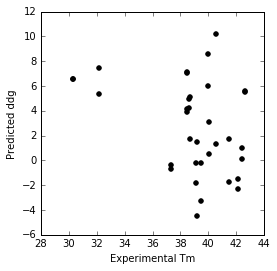

In [23]:
plt.figure( figsize=( 4, 4 ) )
plt.scatter( joined.tm, joined.total, color='k' )
plt.xlabel( 'Experimental Tm' )
plt.ylabel( 'Predicted ddg' )